# Anomaly detection for time series

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import pandas as pd

from TSB_UAD.utils.max_mean_discrepancy import calculate_mmd
from TSB_UAD.utils.shapelets import calculate_shapelet_similarity
from TSB_UAD.utils.dtw import compute_dtw_distance

from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length
from TSB_UAD.utils.visualisation import plotFig
from sklearn.preprocessing import MinMaxScaler

from TSB_UAD.models.iforest import IForest
from TSB_UAD.models.AE import AE_MLP2
from TSB_UAD.models.custom_lstm import CustomLstm

##  Data preprocessing

Here we load and prepare the time series (here, we load only a snippet of 10,000 points). We asutomatically estimate the subsequence length for the anomaly detection methods that require a subsequence length parameter.
In order to do this, we use auto-correlation

In [2]:
# Prepare data for unsupervised method

filepath = 'data/TSB-UAD-Synthetic/MGAB_add_point_outlier_0.02/10.test.out'
df = pd.read_csv(filepath, header=None).dropna().to_numpy()

name = filepath.split('/')[-1]
max_length = 10000

data = df[:max_length,0].astype(float)
label = df[:max_length,1].astype(int)
    
slidingWindow = find_length(data)
X_data = Window(window = slidingWindow).convert(data).to_numpy()


# Prepare data for semisupervised method. 
# Here, the training ratio = 0.1

data_train = data[:int(0.1*len(data))]
data_test = data

X_train = Window(window = slidingWindow).convert(data_train).to_numpy()
X_test = Window(window = slidingWindow).convert(data_test).to_numpy()

print("Estimated Subsequence length: ",slidingWindow)
print("Time series length: ",len(data))
print("Number of abnormal points: ",list(label).count(1))

Estimated Subsequence length:  48
Time series length:  10000
Number of abnormal points:  206


# Dataset similarity

Here we are demonstrating and experimenting with datasets that we are trying to find their similarities between them

In [3]:
filepath = 'data/TSB-UAD-Synthetic/YAHOO_add_point_outlier_0.02/Yahoo_A1real_60_data.out'
df2 = pd.read_csv(filepath, header=None).dropna().to_numpy()
name2 = filepath.split('/')[-1]
max_length = 10000

data2 = df2[:max_length,0].astype(float)
label2 = df2[:max_length,1].astype(int)

slidingWindow2 = find_length(data2)

data_train2 = data2[:int(0.1*len(data2))]
data_test2 = data2

X_train2 = Window(window = slidingWindow).convert(data_train2).to_numpy()
X_test2 = Window(window = slidingWindow).convert(data_test2).to_numpy()

print("Estimated Subsequence length: ",slidingWindow2)
print("Time series length: ",len(data2))
print("Number of abnormal points: ",list(label2).count(1))

Estimated Subsequence length:  100
Time series length:  1461
Number of abnormal points:  45


Use Maximum Mean Discrepancy (MMD) with an RBF kernel to compute pairwise similarities between datasets.

In [4]:
mmd_value = calculate_mmd(data, data2, gamma=1.0)
print("MMD value:", mmd_value)

MMD value: 0.008996904838449948


Use Dynamic Time Warping (DTW) to find time series alignment/similarity

In [5]:
dtw_value = compute_dtw_distance(data, data2)
print("DTW value:", dtw_value)

DTW value: 2585.59


Shapelets are small, discriminative subsequences of a time series that can represent key patterns or features.

1. Extract shapelets from both datasets.
2. Calculate distances between shapelets from both datasets to measure similarity.

In [6]:
shapelet_value = calculate_shapelet_similarity(data, data2)
print('Shapelet similarity value:', shapelet_value)

Shapelet similarity value: 1.0


## Display the results of anomaly detectors

For each output figure, the left panel shows the real time series with outliers (red), anomaly score obtained by each anomaly detector, and the correpsonding TP/FP/TN/FN classification. 

The right panel shows the ROC curve. AUC represents the area under the ROC curve. Larger AUC indicates better performance.

49 49
83 83
179 179
274 274
304 304
354 354
413 413
431 431
448 448
485 485
492 492
526 526
646 646
662 662
727 727
755 755
797 797
917 917
966 966
992 993
1085 1085
1096 1096
1284 1284
1286 1286
1348 1348
1474 1474
1588 1588
1643 1643
1665 1665
1751 1751
1789 1789
1793 1793
1954 1954
2003 2003
2050 2050
2098 2098
2194 2194
2207 2207
2212 2212
2225 2225
2232 2232
2324 2324
2328 2328
2383 2383
2413 2413
2452 2452
2487 2487
2543 2543
2652 2652
2654 2654
2741 2741
2805 2805
2810 2810
2813 2813
2990 2990
3099 3099
3133 3133
3178 3178
3198 3198
3260 3260
3354 3354
3449 3449
3481 3481
3611 3611
3620 3620
3707 3707
3723 3723
3727 3728
3763 3763
3841 3841
3843 3843
3898 3898
3929 3929
4032 4032
4057 4057
4104 4104
4171 4171
4206 4206
4269 4269
4313 4313
4358 4358
4412 4412
4575 4575
4626 4626
4747 4747
4799 4799
4802 4802
4877 4877
4879 4879
4962 4962
5089 5089
5098 5098
5159 5159
5204 5204
5337 5337
5447 5447
5477 5477
5484 5484
5499 5499
5571 5571
5671 5671
5697 5697
5703 5703
5742 5742
5773

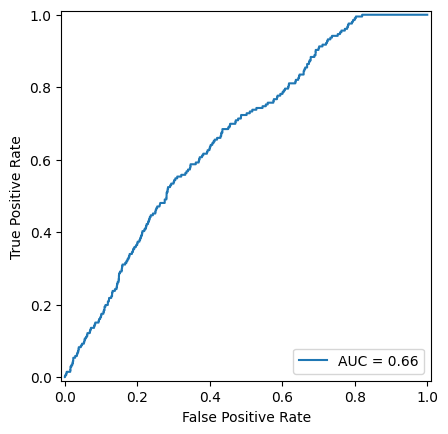

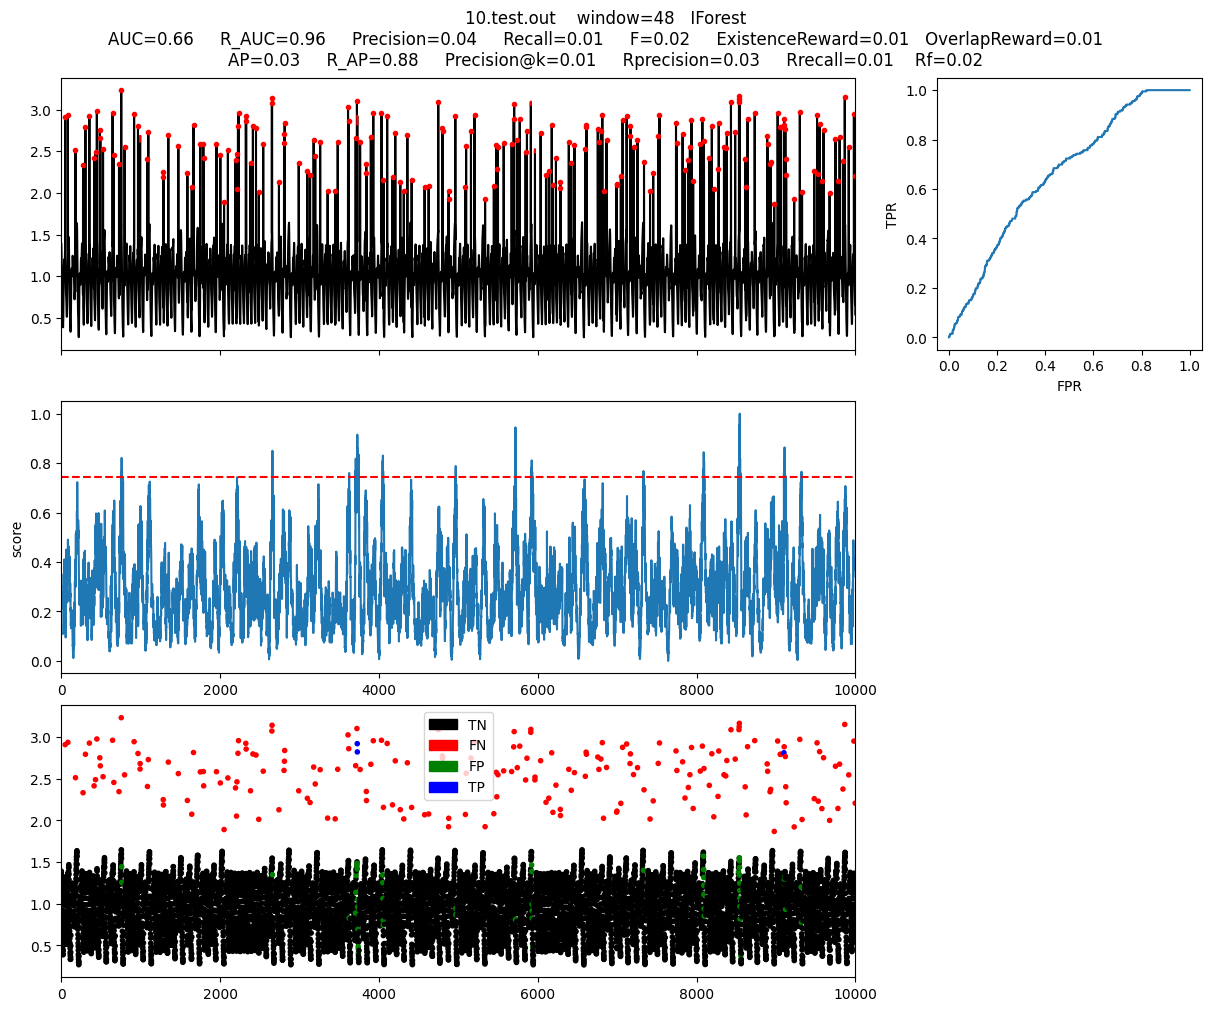

In [7]:
modelName='IForest'
clf = IForest(n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) 

310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
49 49
83 83
179 179
274 274
304 304
354 354
413 413
431 431
448 448
485 485
492 492
526 526
646 646
662 662
727 727
755 755
797 797
917 917
966 966
992 993
1085 1085
1096 1096
1284 1284
1286 1286
1348 1348
1474 1474
1588 1588
1643 1643
1665 1665
1751 1751
1789 1789
1793 1793
1954 1954
2003 2003
2050 2050
2098 2098
2194 2194
2207 2207
2212 2212
2225 2225
2232 2232
2324 2324
2328 2328
2383 2383
2413 2413
2452 2452
2487 2487
2543 2543
2652 2652
2654 2654
2741 2741
2805 2805
2810 2810
2813 2813
2990 2990
3099 3099
3133 3133
3178 3178
3198 3198
3260 3260
3354 3354
3449 3449
3481 3481
3611 3611
3620 3620
3707 3707
3723 3723
3727 3728
3763 3763
3841 3841
3843 3843
3898 3898
3929 3929
4032 4032
4057 4057
4104 4104
4171 4171
4206 4206
4269 4269
4313 4313
4358 4358
4412 4412
4575 4575
4626 4626
4747 4747
4799 4799
4802 4802
4877 4877
4879 4879
4962 4962
5089 5089
5098 5098
5159 5159
5204 5204
5337 5337
5447 5447
5477 5477
5484 5484
5499 5499
5571 5571
56

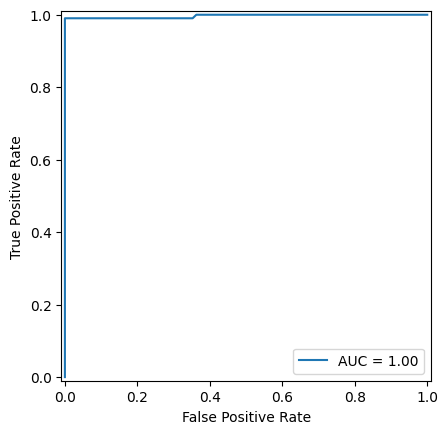

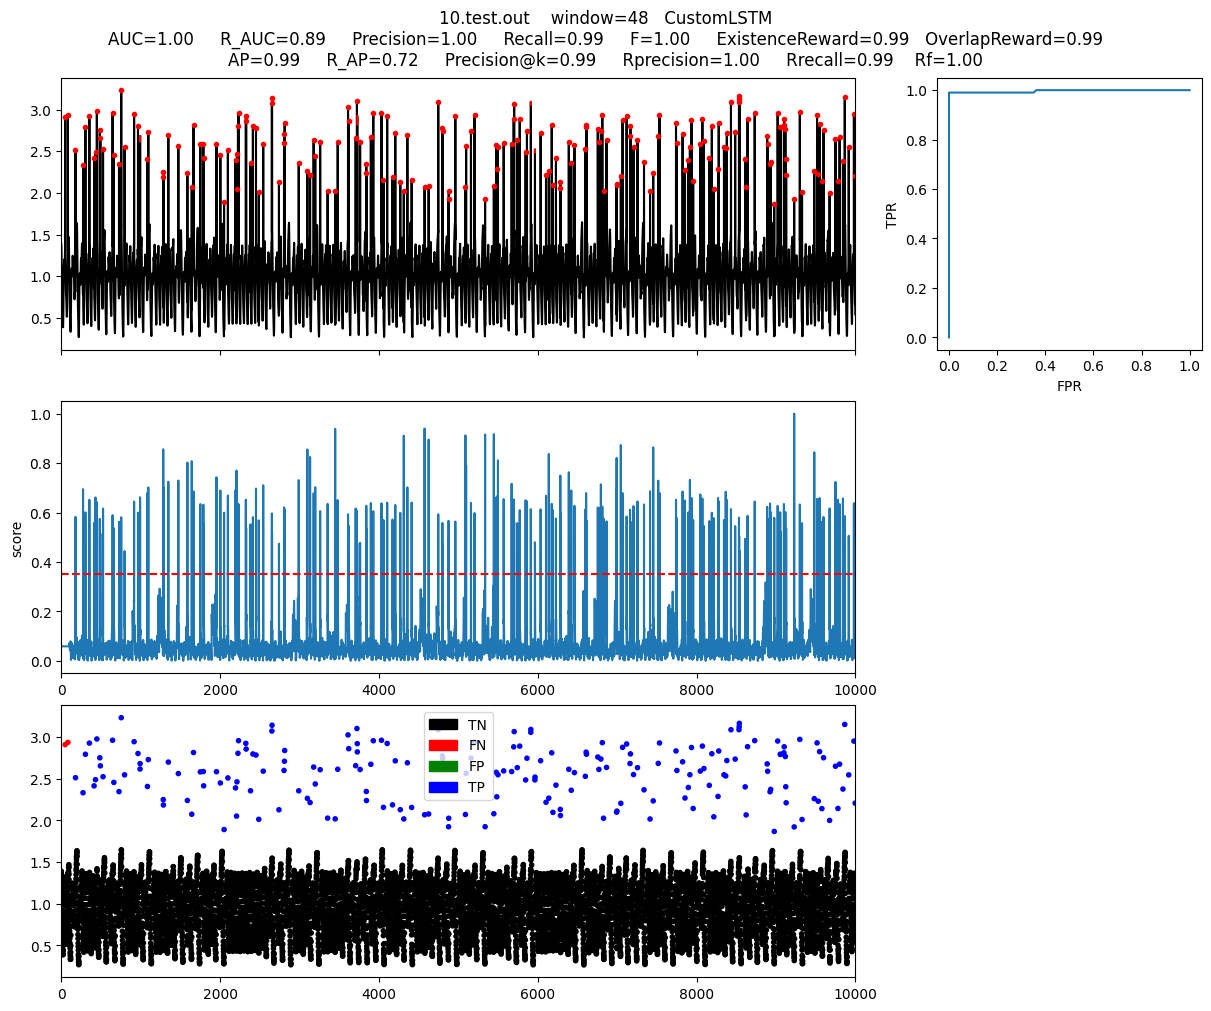

In [8]:
modelName='CustomLSTM'
clf = CustomLstm(slidingwindow = slidingWindow2, predict_time_steps=1, epochs = 50, patience = 5, verbose=0)
clf.fit(data_train, data_test)

measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

In [9]:
measure = Fourier()
measure.detector = clf
measure.set_param()

clf.predict_proba(data_test, measure=measure)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

# plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

TypeError: CustomLstm.fit() missing 1 required positional argument: 'X_dirty'

In [ ]:
modelName='AE'
clf = AE_MLP2(slidingWindow = slidingWindow, epochs=100, verbose=0)

clf.fit(data_train, data_test)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)